In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [46]:
df = pd.read_csv('winequality-red.csv')

# Initial data exploration

In [47]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [48]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


No categorical data, pure regression problem. Let's explore correlations.

In [5]:
correlations = df.corr()['quality'].drop('quality')
print(correlations)

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64


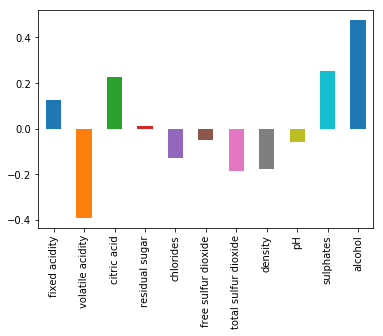

In [6]:
_ = correlations.plot(kind='bar')

Let's have a quick look on the whole correlation matrix to understand how different features correlate with each other.

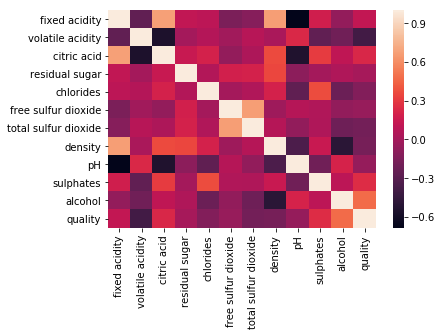

In [7]:
import seaborn as sns
sns.heatmap(df.corr())

As suspected, acidity somewhat correlate with each other and pH.

Let's split data into train (80%), validation (10%) and test (10%) sets.

In [8]:
train = df.sample(frac=0.8)
test_and_validation = df.loc[~df.index.isin(train.index)]
validation = test_and_validation.sample(frac=0.5)
test = test_and_validation.loc[~test_and_validation.index.isin(validation.index)]

print(train.shape, validation.shape, test.shape)

(1279, 12) (160, 12) (160, 12)


In [9]:
def get_features(correlation_threshold):
    abs_corrs = correlations.abs()
    high_correlations = abs_corrs[abs_corrs > correlation_threshold].index.values.tolist()
    return high_correlations

In [10]:
def compare_predictions(predicted, test_df, target_col):
    # Since we have to predict integer values, and the regressor will return float, let's round predicted dataframe
    predicted = predicted.round(0)
    check_df = pd.DataFrame(data=predicted, index=test_df.index, columns=["Predicted "+target_col])
    check_df = pd.concat([check_df, test_df[[target_col]]], axis=1)
    check_df["Error, %"] = np.abs(check_df["Predicted "+target_col]*100/check_df[target_col] - 100)
    check_df['Error, val'] = check_df["Predicted "+target_col] - check_df[target_col]
    return (check_df.sort_index(), check_df["Error, %"].mean())

In [11]:
def evaluate_predictions(model, train_df, test_df, features, target_col):
    train_pred = model.predict(train_df[features])
    train_rmse = mean_squared_error(train_pred, train_df[target_col]) ** 0.5

    test_pred = model.predict(test_df[features])
    test_rmse = mean_squared_error(test_pred, test_df[target_col]) ** 0.5

    print("RMSEs:")
    print(train_rmse, test_rmse)
    
    return test_pred

# Linear regression approach

In [12]:
def lr_model_evaluation(feature_correlation_threshold=0):
    lr = LinearRegression()
    features = get_features(feature_correlation_threshold)
    lr.fit(train[features], train['quality'])
    lr_validation_predictions = evaluate_predictions(lr, train, validation, features, 'quality')
    check_df, avg_error = compare_predictions(lr_validation_predictions, validation, 'quality')
    print("Average validation error:", avg_error)
    return check_df

In [13]:
check = lr_model_evaluation()

RMSEs:
0.6322235496791537 0.7188755791149464
Average validation error: 10.19047619047619


Let's try different feature selection thresholds in hopes for better results

In [14]:
thresholds = [x * 0.05 for x in range(1, 8)] #threshold will scale up to 0.4

for thr in thresholds:
    print('For threshold =', thr)
    _ = lr_model_evaluation(thr)
    print()

For threshold = 0.05
RMSEs:
0.6326552929783933 0.7167580970710794
Average validation error: 9.997023809523808

For threshold = 0.1
RMSEs:
0.6348163603225545 0.7196414169866523
Average validation error: 9.538690476190474

For threshold = 0.15000000000000002
RMSEs:
0.6416444948237876 0.7223144324227667
Average validation error: 9.325892857142858

For threshold = 0.2
RMSEs:
0.6448508156283852 0.7296859005868478
Average validation error: 9.325892857142858

For threshold = 0.25
RMSEs:
0.6450794951577195 0.7282114788384293
Average validation error: 9.325892857142858

For threshold = 0.30000000000000004
RMSEs:
0.658083794278339 0.7225062993860253
Average validation error: 9.325892857142858

For threshold = 0.35000000000000003
RMSEs:
0.658083794278339 0.7225062993860253
Average validation error: 9.325892857142858



The best result so far was achieved with feature selection threshold of 0.15, but improvement was not too impressive.

In [15]:
print(get_features(0.15))

['volatile acidity', 'citric acid', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']


# Decision tree approach

In [16]:
def dtr_model_evaluation(feature_correlation_threshold=0, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0., max_leaf_nodes=None):
    dtr = DecisionTreeRegressor(random_state=42, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_leaf_nodes=max_leaf_nodes)
    features = get_features(feature_correlation_threshold)
    dtr.fit(train[features], train['quality'])
    dtr_validation_predictions = evaluate_predictions(dtr, train, validation, features, 'quality')
    check_df, avg_error = compare_predictions(dtr_validation_predictions, validation, 'quality')
    print("Average validation error:", avg_error)
    return check_df, avg_error

In [17]:
check, error = dtr_model_evaluation()

RMSEs:
0.0 0.7541551564499178
Average validation error: 7.854166666666666


Average error dropped, but there is still room for improvements! As RMSEs suggest, an overfitting takes place. Let's start by trying different combinations for hyperparams of decision tree and then move on to random forests.

The above method is computationally impractical. Better approach would to use default parameters and change only one at the time to understand how it affects the results, and only then, with narrowed lists of hyperparameters, try every plausible combination.

In [18]:
thresholds = [0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4]
max_depth_list = [None, 3, 4, 5, 7, 10, 15, 20]
min_samples_split_list = [2, 3, 4, 5, 7, 10, 15, 20]
min_samples_leaf_list = [1, 2, 3, 5, 7, 10, 0.01, 0.03, 0.05, 0.07, 0.1]
min_weight_fraction_leaf_list = [0., 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.12, 0.15, 0.18, 0.2, 0.23, 0.25, 0.3]
max_leaf_nodes_list = [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

hyperparams = {
    'threshold': thresholds,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'min_weight_fraction_leaf': min_weight_fraction_leaf_list,
    'max_leaf_nodes': max_leaf_nodes_list
}

validation_results = []
for hp_name, hp_list in hyperparams.items():
    errors = []
    for hp_val in hp_list:
        if hp_name == 'threshold':
            _, error = dtr_model_evaluation(feature_correlation_threshold=hp_val)
        elif hp_name == 'max_depth':
            _, error = dtr_model_evaluation(max_depth=hp_val)
        elif hp_name == 'min_samples_split':
            _, error = dtr_model_evaluation(min_samples_split=hp_val)
        elif hp_name == 'min_samples_leaf':
            _, error = dtr_model_evaluation(min_samples_leaf=hp_val)
        elif hp_name == 'min_weight_fraction_leaf':
            _, error = dtr_model_evaluation(min_weight_fraction_leaf=hp_val)
        elif hp_name == 'max_leaf_nodes':
            _, error = dtr_model_evaluation(max_leaf_nodes=hp_val)
            
        errors.append(error)
    validation_results.append((hp_name, errors))

RMSEs:
0.0 0.7541551564499178
Average validation error: 7.854166666666666
RMSEs:
0.0 0.7541551564499178
Average validation error: 8.124999999999998
RMSEs:
0.0 0.832916562447884
Average validation error: 8.630208333333332
RMSEs:
0.0 0.8587782018658834
Average validation error: 8.860863095238095
RMSEs:
0.019771960307117736 0.6800735254367721
Average validation error: 6.720238095238093
RMSEs:
0.06355796002068616 0.7910084983389524
Average validation error: 8.146577380952381
RMSEs:
0.26802807383495664 0.7323767169090791
Average validation error: 9.175595238095239
RMSEs:
0.26802807383495664 0.7323767169090791
Average validation error: 9.175595238095239
RMSEs:
0.671478304394186 0.7714905778039117
Average validation error: 10.085565476190478
RMSEs:
0.0 0.7541551564499178
Average validation error: 7.854166666666666
RMSEs:
0.6440822481741727 0.7067297286220071
Average validation error: 8.694940476190474
RMSEs:
0.6132696478298403 0.7206660040688727
Average validation error: 10.038690476190476
RM

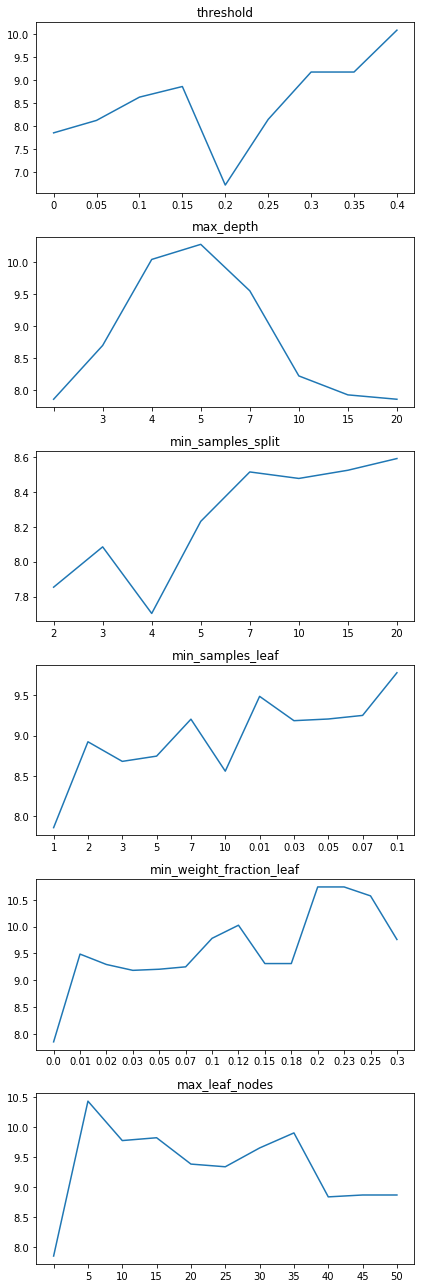

In [19]:
fig = plt.figure(figsize=(6, 18))

for i, result in enumerate(validation_results):
    ax = fig.add_subplot(len(validation_results), 1, i+1)
    hp_name = result[0]
    hp_errors = result[1]
    
    ax.set_title(hp_name)
    ax.plot(range(0, len(hp_errors)), hp_errors)
    plt.sca(ax)
    x_labels = hyperparams[hp_name]
    plt.xticks(range(0, len(hp_errors)), x_labels)
    
fig.tight_layout()
plt.show()

Now, based on graphics above, it is easy to select best hyperparameters. For hyperparameters where it is still not crystally clear what is the best hyperparameter let's use several and search among them.

In [20]:
thresholds = [0.2]
max_depth_list = [5, 6]
min_samples_split_list = [3]
min_samples_leaf_list = [0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095]
min_weight_fraction_leaf_list = [0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095]
max_leaf_nodes_list = [None]

results = []
for max_depth in max_depth_list:
    for min_samples_split in min_samples_split_list:
        for min_samples_leaf in min_samples_leaf_list:
            for min_weight_fraction_leaf in min_weight_fraction_leaf_list:
                for max_leaf_nodes in max_leaf_nodes_list:
                    for thr in thresholds: 
                        hyperparameters = {
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'min_weight_fraction_leaf': min_weight_fraction_leaf,
                            'max_leaf_nodes': max_leaf_nodes,
                            'threshold': thr
                        }

                        check, error = dtr_model_evaluation(thr, max_depth=max_depth, min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                            max_leaf_nodes=max_leaf_nodes)
                        
                        results.append((hyperparameters, error))

RMSEs:
0.6419787350296785 0.7049949335410327
Average validation error: 9.211309523809522
RMSEs:
0.6446420683665374 0.7096494016393075
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6458213970479898 0.7101225147295681
Average validation error: 9.553571428571429
RMSEs:
0.6471737009130109 0.707941745808812
Average validation error: 9.449404761904763
RMSEs:
0.6484763906380857 0.7058566374857336
Average validation error: 9.345238095238095
RMSEs:
0.6591436870080475 0.7131876510956219
Average validation error: 9.397321428571427
RMSEs:
0.6591436870080475 0.7131876510956219
Average validation error: 9.397321428571427
RMSEs:
0.6446420683665374 0.7096494016393075
Average validation error: 9.553571428571429
RMSEs:
0.6446420683665374 0.7096494016393075
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722

RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6458213970479898 0.7101225147295681
Average validation error: 9.553571428571429
RMSEs:
0.6471737009130109 0.707941745808812
Average validation error: 9.449404761904763
RMSEs:
0.6484763906380857 0.7058566374857336
Average validation error: 9.345238095238095
RMSEs:
0.6591436870080475 0.7131876510956219
Average validation error: 9.397321428571427
RMSEs:
0.6591436870080475 0.7131876510956219
Average validation error: 9.397321428571427
RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429
RMSEs:
0.6457142651722

In [21]:
min(results, key = lambda x: x[1])

({'max_depth': 5,
  'min_samples_split': 3,
  'min_samples_leaf': 0.055,
  'min_weight_fraction_leaf': 0.055,
  'max_leaf_nodes': None,
  'threshold': 0.2},
 9.211309523809522)

So far the best result for validation set with Decision Tree Regressor is ~8% of errors, with the following hyperparameters (apart from default ones): Feature Selection Correlation Threshold = 0.2, max_depth=5, min_samples_split=3,         min_samples_leaf=0.055, min_weight_fraction_leaf=0.07

In [22]:
check, error = dtr_model_evaluation(0.2, max_depth=5, min_samples_split=3, min_samples_leaf=0.055, min_weight_fraction_leaf=0.07)
check.head(10)

RMSEs:
0.6457142651722882 0.7099451473992094
Average validation error: 9.553571428571429


,Predicted quality,quality,"Error, %","Error, val"
8,5.0,7,28.571429,-2.0
9,6.0,5,20.000000,1.0
11,6.0,5,20.000000,1.0
22,5.0,5,0.000000,0.0
27,5.0,5,0.000000,0.0
92,5.0,5,0.000000,0.0
100,6.0,6,0.000000,0.0
101,5.0,6,16.666667,-1.0
102,5.0,6,16.666667,-1.0
109,5.0,5,0.000000,0.0


RMSEs for train and validation sets are quite close, it's unlikely there is a lot of overfitting.

### Random Forest approach

Let's use random forest with newly found best hyperparameters for decision tree.

In [23]:
def rfr_model_evaluation(n_estimators=100):
    rfr = RandomForestRegressor(random_state=42, n_estimators=n_estimators, max_depth=5, min_samples_split=3, min_samples_leaf=0.055, min_weight_fraction_leaf=0.07)
    features = get_features(0.2)
    rfr.fit(train[features], train['quality'])
    rfr_validation_predictions = evaluate_predictions(rfr, train, validation, features, 'quality')
    check_df, avg_error = compare_predictions(rfr_validation_predictions, validation, 'quality')
    print("Average validation error:", avg_error)
    return check_df, avg_error

In [24]:
check, error = rfr_model_evaluation()

RMSEs:
0.6221354449266246 0.7038959380018055
Average validation error: 9.752976190476188


Random forest didn't showed any improvements in comparison with tuned decision tree. Perhaps using the same tuning for random forest as for decision tree is not as effective. Let's run random forest regressor with all default hyperparameters.

In [25]:
rfr = RandomForestRegressor(random_state=42, n_estimators=100)
features = get_features(0.2)
rfr.fit(train[features], train['quality'])
rfr_validation_predictions = evaluate_predictions(rfr, train, validation, features, 'quality')
check_df, avg_error = compare_predictions(rfr_validation_predictions, validation, 'quality')
print("Average validation error:", avg_error)

RMSEs:
0.2242177718209219 0.6501534674597991
Average validation error: 7.963541666666666


We got a significant improvement. Let's try to tune hyperparameters as we did it with a single decision tree.

In [26]:
def rfr_model_evaluation(feature_correlation_threshold=0, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0., max_leaf_nodes=None):
    rfr = RandomForestRegressor(random_state=42, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_leaf_nodes=max_leaf_nodes)
    features = get_features(feature_correlation_threshold)
    rfr.fit(train[features], train['quality'])
    rfr_validation_predictions = evaluate_predictions(rfr, train, validation, features, 'quality')
    check_df, avg_error = compare_predictions(rfr_validation_predictions, validation, 'quality')
    print("Average validation error:", avg_error)
    return check_df, avg_error

In [27]:
thresholds = [0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4]
max_depth_list = [None, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35]
min_samples_split_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
min_samples_leaf_list = [1, 2, 3, 5, 7, 10, 0.01, 0.03, 0.05, 0.07, 0.1]
min_weight_fraction_leaf_list = [0., 0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.12, 0.15, 0.18, 0.2, 0.23, 0.25, 0.3]
max_leaf_nodes_list = [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
n_estimators = [10, 20, 40, 50, 75, 100, 125, 150, 175, 200, 225]

hyperparams = {
    'threshold': thresholds,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'min_weight_fraction_leaf': min_weight_fraction_leaf_list,
    'max_leaf_nodes': max_leaf_nodes_list,
    'n_estimators': n_estimators
}

validation_results = []
for hp_name, hp_list in hyperparams.items():
    errors = []
    for hp_val in hp_list:
        if hp_name == 'threshold':
            _, error = rfr_model_evaluation(feature_correlation_threshold=hp_val)
        elif hp_name == 'max_depth':
            _, error = rfr_model_evaluation(max_depth=hp_val)
        elif hp_name == 'min_samples_split':
            _, error = rfr_model_evaluation(min_samples_split=hp_val)
        elif hp_name == 'min_samples_leaf':
            _, error = rfr_model_evaluation(min_samples_leaf=hp_val)
        elif hp_name == 'min_weight_fraction_leaf':
            _, error = rfr_model_evaluation(min_weight_fraction_leaf=hp_val)
        elif hp_name == 'max_leaf_nodes':
            _, error = rfr_model_evaluation(max_leaf_nodes=hp_val)
        elif hp_name == 'n_estimators':
            _, error = rfr_model_evaluation(n_estimators=hp_val)
            
        errors.append(error)
    validation_results.append((hp_name, errors))

RMSEs:
0.21328529642254931 0.6096643543787025
Average validation error: 6.753720238095236
RMSEs:
0.21385493391542018 0.6178202610792236
Average validation error: 7.264136904761903
RMSEs:
0.21232434215257526 0.618207590538971
Average validation error: 6.889136904761905
RMSEs:
0.21821240486198956 0.6321006644514781
Average validation error: 7.655505952380952
RMSEs:
0.2242177718209219 0.6501534674597991
Average validation error: 7.963541666666666
RMSEs:
0.23353209165162456 0.6716788465953148
Average validation error: 8.222470238095237
RMSEs:
0.33984476798281854 0.6821286960728332
Average validation error: 8.149553571428571
RMSEs:
0.33984476798281854 0.6821286960728332
Average validation error: 8.149553571428571
RMSEs:
0.6731715499087597 0.76677725427364
Average validation error: 10.10639880952381
RMSEs:
0.21328529642254931 0.6096643543787025
Average validation error: 6.753720238095236
RMSEs:
0.607530569278812 0.6922276523147958
Average validation error: 9.680059523809522
RMSEs:
0.57003261

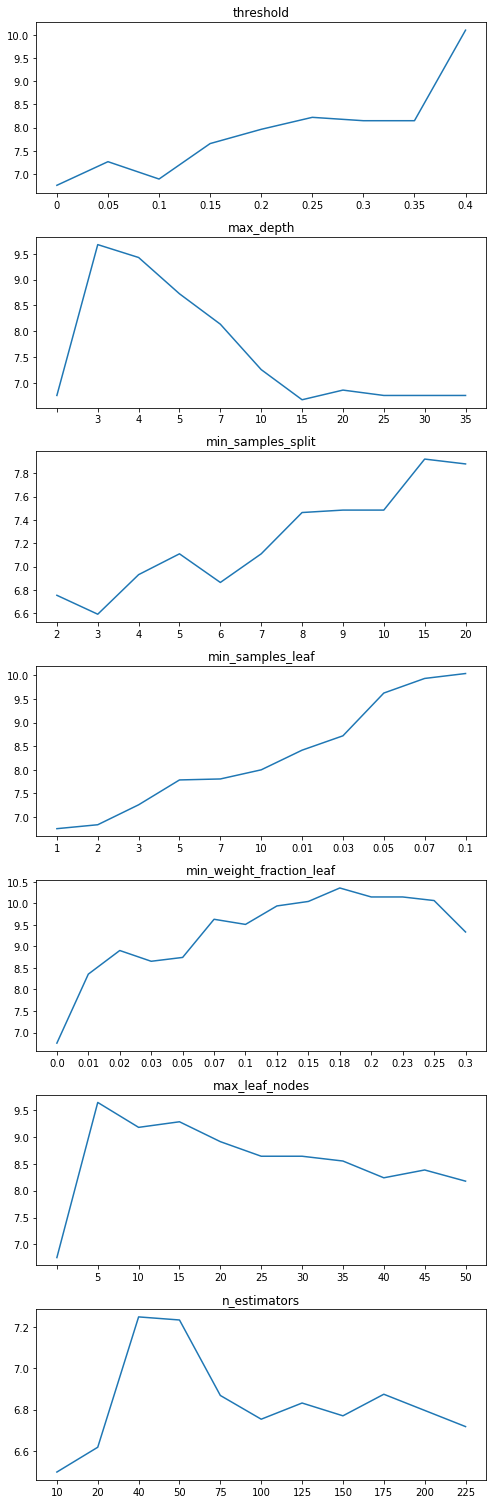

In [28]:
fig = plt.figure(figsize=(7, 21))

for i, result in enumerate(validation_results):
    ax = fig.add_subplot(len(validation_results), 1, i+1)
    hp_name = result[0]
    hp_errors = result[1]
    
    ax.set_title(hp_name)
    ax.plot(range(0, len(hp_errors)), hp_errors)
    plt.sca(ax)
    x_labels = hyperparams[hp_name]
    plt.xticks(range(0, len(hp_errors)), x_labels)
    
fig.tight_layout()
plt.show()

As with decision tree, let's narrow down best hyperparameters with additional parameter search. We should expect that best results should have less than 5.5% of errors.

In [29]:
thresholds = [0.05, 0.15]
max_depth_list = [16, 17, 18, 19, 20, 21, 22, 23, 24]
min_samples_split_list = [7]
min_samples_leaf_list = [1, 2]
min_weight_fraction_leaf_list = [0.0]
max_leaf_nodes_list = [None]
n_estimators = [130, 140, 150, 160, 170]

results = []
for n_estimator in n_estimators:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                for min_weight_fraction_leaf in min_weight_fraction_leaf_list:
                    for max_leaf_nodes in max_leaf_nodes_list:
                        for thr in thresholds:
                            hyperparameters = {
                                'max_depth': max_depth,
                                'min_samples_split': min_samples_split,
                                'min_samples_leaf': min_samples_leaf,
                                'min_weight_fraction_leaf': min_weight_fraction_leaf,
                                'max_leaf_nodes': max_leaf_nodes,
                                'threshold': thr,
                                'n_estimators': n_estimator
                            }

                            check, error = rfr_model_evaluation(thr, n_estimators=n_estimator, max_depth=max_depth, min_samples_split=min_samples_split,
                                min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                                max_leaf_nodes=max_leaf_nodes)

                            results.append((hyperparameters, error))

RMSEs:
0.28519878567969165 0.626789260603426
Average validation error: 7.463541666666664
RMSEs:
0.3058550518535415 0.6384994028102315
Average validation error: 7.749255952380951
RMSEs:
0.3155076163933458 0.6251839824826745
Average validation error: 7.124255952380951
RMSEs:
0.3370178499024483 0.6468152940474656
Average validation error: 7.859374999999998
RMSEs:
0.283874498313585 0.6262918884525245
Average validation error: 7.494791666666664
RMSEs:
0.3046871999412376 0.6387390157301565
Average validation error: 7.790922619047618
RMSEs:
0.3151071719656452 0.625842936232322
Average validation error: 7.374255952380951
RMSEs:
0.33625177005642004 0.64686499048426
Average validation error: 7.859374999999998
RMSEs:
0.2831503686218355 0.626614094991033
Average validation error: 7.463541666666664
RMSEs:
0.3040589921355216 0.6379352821340698
Average validation error: 7.540922619047616
RMSEs:
0.31517029756572507 0.6256295395769331
Average validation error: 7.124255952380951
RMSEs:
0.336199980942774

RMSEs:
0.281776299071893 0.6284616940739556
Average validation error: 7.901041666666664
RMSEs:
0.3028339236028634 0.638522815545245
Average validation error: 7.645089285714283
RMSEs:
0.3141465409895469 0.6245334981611209
Average validation error: 7.56770833333333
RMSEs:
0.3356628711559934 0.6454892845995399
Average validation error: 7.734374999999997
RMSEs:
0.28170993137590367 0.6284190122951306
Average validation error: 7.901041666666664
RMSEs:
0.30288709478832476 0.638569087354168
Average validation error: 7.801339285714283
RMSEs:
0.3141465409895469 0.6245334981611209
Average validation error: 7.56770833333333
RMSEs:
0.33567666203000335 0.6455199944337198
Average validation error: 7.734374999999997
RMSEs:
0.28170993137590367 0.6284190122951306
Average validation error: 7.901041666666664
RMSEs:
0.30292390491393023 0.6385654821900871
Average validation error: 7.801339285714283
RMSEs:
0.3141465409895469 0.6245334981611209
Average validation error: 7.56770833333333
RMSEs:
0.3356766620300

In [30]:
min(results, key = lambda x: x[1])

({'max_depth': 21,
  'min_samples_split': 7,
  'min_samples_leaf': 2,
  'min_weight_fraction_leaf': 0.0,
  'max_leaf_nodes': None,
  'threshold': 0.05,
  'n_estimators': 160},
 7.088541666666666)

The best results on validation set found with random forest regressor have ~5.13% of errors with the hyperparameters shown above.

In [31]:
check, error = rfr_model_evaluation(0.05, n_estimators=130, max_depth=19, min_samples_split=7,
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                max_leaf_nodes=None)

RMSEs:
0.28280940306367114 0.626496011802538
Average validation error: 7.619791666666664


In [32]:
check.head(10)

,Predicted quality,quality,"Error, %","Error, val"
8,5.0,7,28.571429,-2.0
9,5.0,5,0.000000,0.0
11,5.0,5,0.000000,0.0
22,6.0,5,20.000000,1.0
27,6.0,5,20.000000,1.0
92,6.0,5,20.000000,1.0
100,6.0,6,0.000000,0.0
101,6.0,6,0.000000,0.0
102,6.0,6,0.000000,0.0
109,5.0,5,0.000000,0.0


# Gradient boosted tree approach

In [44]:
import xgboost as xgb

In [83]:
def xgbr_model_evaluation(feature_correlation_threshold=0, learning_rate=0.3, gamma=0, max_depth=3,
        min_child_weight=1, max_delta_step=0, subsample=1., reg_lambda=1, reg_alpha=0, n_estimators=100):

    xgbr = xgb.XGBRegressor(max_depth=max_depth, min_child_weight=min_child_weight, max_delta_step=max_delta_step,
                           learning_rate=learning_rate, reg_lambda=reg_lambda, reg_alpha=reg_alpha, gamma=gamma,
                           n_estimators=n_estimators, subsample=subsample)
    features = get_features(feature_correlation_threshold)
    xgbr.fit(train[features], train['quality'])
    xgbr_validation_predictions = evaluate_predictions(xgbr, train, validation, features, 'quality')
    check_df, avg_error = compare_predictions(xgbr_validation_predictions, validation, 'quality')
    print("Average validation error:", avg_error)
    return check_df, avg_error

In [84]:
check_df, avg_error = xgbr_model_evaluation()

RMSEs:
0.34912933174805794 0.6660665674053683
Average validation error: 8.191220238095237


~8.2% errors with default parameters. Let's try to tune the model.

In [105]:
thresholds = [0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4]
max_depth_list = [3, 4, 5, 7, 10, 15, 20, 25, 30, 35]
max_delta_steps = [x for x in range(0,11)]
min_child_weights = [0, 1, 3, 10, 30, 100, 300, 1000, 3000]
learning_rates = [0.03, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
gammas = [0, 0.01, 0.03, 0.1, 0.3, 0.5, 1, 3, 10, 30]
subsamples = [1., 0.9, 0.8, 0.7, 0.6, 0.5, 0.6]
reg_lambdas = [0.1, 0.3, 1, 1.3, 1.5, 2, 3, 3.5, 4, 4.5, 5, 5.5, 10]
reg_alphas = [0.1, 0.3, 1, 1.3, 1.5, 1.75, 2, 2.25, 2.5, 3]
n_estimators = [10, 20, 40, 50, 75, 100, 125, 150, 175, 200, 225]

hyperparams = {
    'threshold': thresholds,
    'max_depth': max_depth_list,
    'max_delta_step': max_delta_steps,
    'min_child_weight': min_child_weights,
    'learning_rate': learning_rates,
    'gamma': gammas,
    'subsample': subsamples,
    'reg_lambda': reg_lambdas,
    'reg_alpha': reg_alphas,
    'n_estimators': n_estimators,
}

validation_results = []
for hp_name, hp_list in hyperparams.items():
    errors = []
    for hp_val in hp_list:
        if hp_name == 'threshold':
            _, error = xgbr_model_evaluation(feature_correlation_threshold=hp_val)
        elif hp_name == 'max_depth':
            _, error = xgbr_model_evaluation(max_depth=hp_val)
        elif hp_name == 'max_delta_step':
            _, error = xgbr_model_evaluation(max_delta_step=hp_val)
        elif hp_name == 'min_child_weight':
            _, error = xgbr_model_evaluation(min_child_weight=hp_val)
        elif hp_name == 'learning_rate':
            _, error = xgbr_model_evaluation(learning_rate=hp_val)
        elif hp_name == 'gamma':
            _, error = xgbr_model_evaluation(gamma=hp_val)
        elif hp_name == 'subsample':
            _, error = xgbr_model_evaluation(subsample=hp_val)
        elif hp_name == 'reg_lambda':
            _, error = xgbr_model_evaluation(reg_lambda=hp_val)
        elif hp_name == 'reg_alpha':
            _, error = xgbr_model_evaluation(reg_alpha=hp_val)
        elif hp_name == 'n_estimators':
            _, error = xgbr_model_evaluation(n_estimators=hp_val)
            
        errors.append(error)
    validation_results.append((hp_name, errors))

RMSEs:
0.34912933174805794 0.6660665674053683
Average validation error: 8.191220238095237
RMSEs:
0.34559272532407065 0.6855333227919099
Average validation error: 8.377976190476192
RMSEs:
0.37173359813921036 0.6742635108475288
Average validation error: 7.494791666666666
RMSEs:
0.3949427814226667 0.6590933857504597
Average validation error: 8.405505952380953
RMSEs:
0.45444543914347874 0.6755827311299438
Average validation error: 8.92782738095238
RMSEs:
0.48250030208524114 0.689294042481413
Average validation error: 8.77083333333333
RMSEs:
0.5299483683753307 0.7025515405624188
Average validation error: 8.604166666666668
RMSEs:
0.5299483683753307 0.7025515405624188
Average validation error: 8.604166666666668
RMSEs:
0.6717872538336738 0.7677688010615606
Average validation error: 10.085565476190478
RMSEs:
0.34912933174805794 0.6660665674053683
Average validation error: 8.191220238095237
RMSEs:
0.22866713541049 0.6567486411744677
Average validation error: 7.5751488095238075
RMSEs:
0.119541272

RMSEs:
0.4363832352564814 0.6576510820366188
Average validation error: 9.052083333333332
RMSEs:
0.38700126765837634 0.6667313319170619
Average validation error: 8.738095238095237
RMSEs:
0.34912933174805794 0.6660665674053683
Average validation error: 8.191220238095237
RMSEs:
0.31666710609974363 0.6799269798494483
Average validation error: 7.664434523809523
RMSEs:
0.2913156865407029 0.6862334657563164
Average validation error: 7.753720238095236
RMSEs:
0.26519728871726334 0.6872646466335794
Average validation error: 8.033482142857142
RMSEs:
0.2415060513180345 0.6843081821275673
Average validation error: 7.819196428571428
RMSEs:
0.22444980326582153 0.6854348099425513
Average validation error: 7.8043154761904745


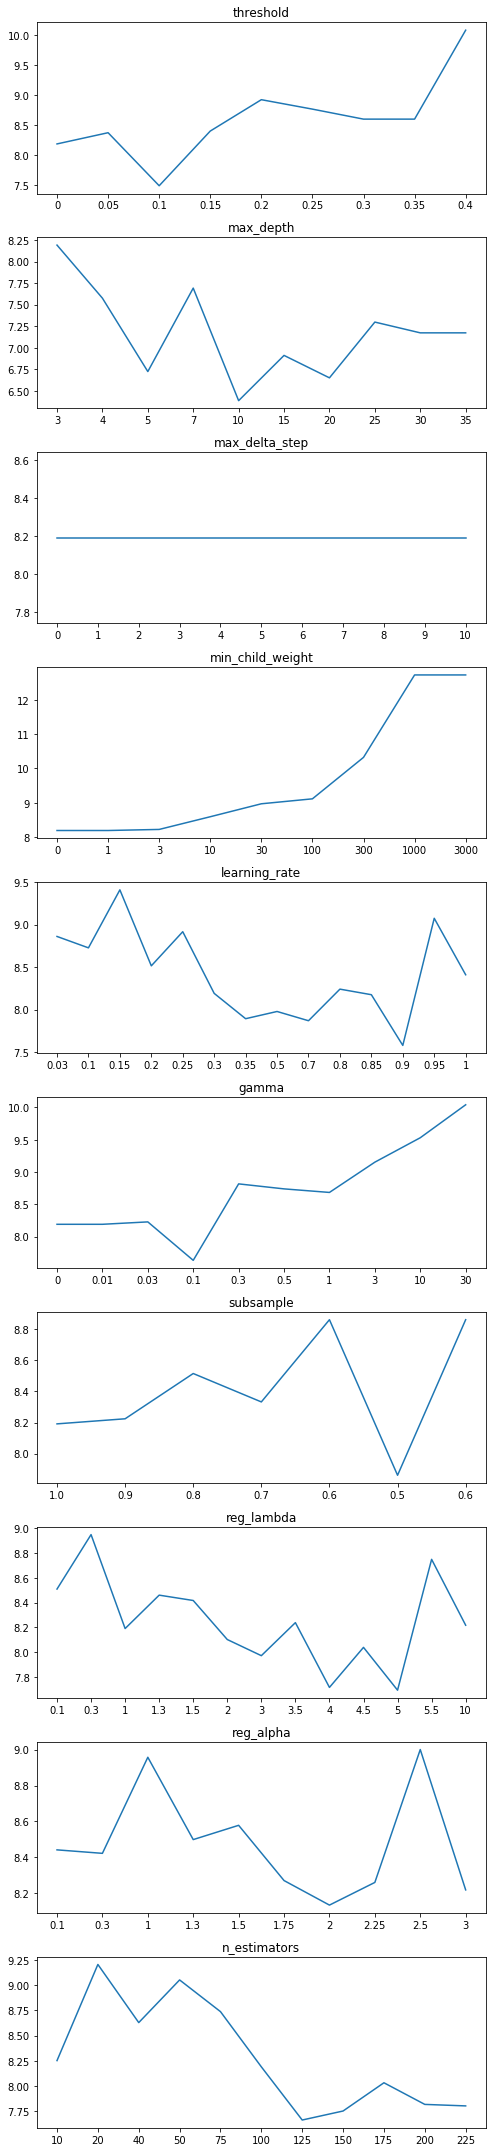

In [106]:
fig = plt.figure(figsize=(7, 30))

for i, result in enumerate(validation_results):
    ax = fig.add_subplot(len(validation_results), 1, i+1)
    hp_name = result[0]
    hp_errors = result[1]
    
    ax.set_title(hp_name)
    ax.plot(range(0, len(hp_errors)), hp_errors)
    plt.sca(ax)
    x_labels = hyperparams[hp_name]
    plt.xticks(range(0, len(hp_errors)), x_labels)
    
fig.tight_layout()
plt.show()

In [107]:
check_df, avg_error = xgbr_model_evaluation(feature_correlation_threshold=0.1, max_depth=10,
    min_child_weight=0, learning_rate=0.9, gamma=0.1, subsample=0.5, reg_lambda=5, reg_alpha=2, n_estimators=125)

RMSEs:
0.2369543823324136 0.7125001492199778
Average validation error: 7.69047619047619


# Final check of best models against the TEST set.

We have tuned 3 models against validation sets. Now it is time to assess models against data that they haven't seen at all before.

### Linear regression

In [33]:
lr = LinearRegression()
features = get_features(0.15)
lr.fit(train[features], train['quality'])
lr_test_predictions = evaluate_predictions(lr, train, test, features, 'quality')
check_df, avg_error = compare_predictions(lr_test_predictions, test, 'quality')
print("Average test error:", avg_error)

RMSEs:
0.6416444948237876 0.6828091466182717
Average test error: 8.142857142857144


### Decision tree

In [34]:
dtr = DecisionTreeRegressor(random_state=42, max_depth=5, min_samples_split=3, min_samples_leaf=0.055, min_weight_fraction_leaf=0.07, max_leaf_nodes=None)
features = get_features(0.2)
dtr.fit(train[features], train['quality'])
dtr_test_predictions = evaluate_predictions(dtr, train, test, features, 'quality')
check_df, avg_error = compare_predictions(dtr_test_predictions, test, 'quality')
print("Average test error:", avg_error)

RMSEs:
0.6457142651722882 0.7054608321659348
Average test error: 8.570684523809526


### Random forest

In [35]:
rfr = RandomForestRegressor(random_state=42, n_estimators=130, max_depth=19, min_samples_split=7, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_leaf_nodes=None)
features = get_features(0.05)
rfr.fit(train[features], train['quality'])
rfr_test_predictions = evaluate_predictions(rfr, train, test, features, 'quality')
check_df, avg_error = compare_predictions(rfr_test_predictions, test, 'quality')
print("Average validation error:", avg_error)

RMSEs:
0.28280940306367114 0.6596264276675314
Average validation error: 8.078125000000004


### Gradient boosted tree

In [108]:
xgbr = xgb.XGBRegressor(max_depth=10, min_child_weight=0, learning_rate=0.9, reg_lambda=5, reg_alpha=2, gamma=0.1,
                           n_estimators=125, subsample=0.5)
features = get_features(0.1)
xgbr.fit(train[features], train['quality'])
xgbr_test_predictions = evaluate_predictions(xgbr, train, test, features, 'quality')
check_df, avg_error = compare_predictions(xgbr_test_predictions, test, 'quality')
print("Average test error:", avg_error)

RMSEs:
0.2369543823324136 0.7344980083825893
Average test error: 8.374255952380953


# Conclusion
We have found an approach that showed about 92.8% of accuracy (~7.2% of errors).

The model above could be improved in the following manner:

* Quality of wine could be regarded as categorical data. In predictions we rounded the values, and that added additional error to that, about which model had no idea. 

* We could ran more precise search for best hyperparameters. Some hyperparameters tend to work better or worse in combination with others. We didn't test that possibility.